# Assignment 2

This homework has two parts:
- **Part 1: Operations (Lecture 3).** We continue the air traffic flow management case study with different parameters and two modeling extensions.
- **Part 2: Planning (Lecture 4).** We explore a new case study focused on bike dock capacity planning for Citi Bike in New York City.

For all questions, select all multiple choice answers that apply.

We start, as usual, by importing all the packages we need.

In [1]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random
import time

#For our visualizations
import re
import seaborn as sns
import geopandas as gpd

# Part 1: Air traffic flow management extensions

Recall from recitation that the goal of this case study is to optimize air traffic flow, with the goal of absorbing delays at departure airports rather than in the terminal airspace of arrival airports. We will investigate four short extensions of the problem:
- Experimenting with different time horizons
- Experimenting with regional weather scenarios (and thus airport capacity levels)
- Modeling extension on aircraft speed
- Modeling extension with airline equity considerations

We will start with the same basic baseline model we created in recitation. Let's load in the data!

In [2]:
# Load capacity data
capacity_full = pd.read_csv("data_atfm/capacity.csv")

# List of airports subject to capacity restrictions
airports = ["ATL", "BOS", "BWI", "CLT", "DCA", "DEN", "DFW", "DTW", "EWR", "FLL", "HNL", "IAD", "IAH", "JFK", "LAS",
            "LAX", "LGA", "MCO", "MDW", "MEM", "MIA", "MSP", "ORD", "PHL", "PHX", "SAN", "SEA", "SFO", "SLC", "TPA"]

K = len(airports)

In [3]:
# Load data for one day of operations
periods_full = pd.read_csv("data_atfm/description_periods.csv")

# Flight schedule: departure and arrival periods
schedule_full = pd.read_csv("data_atfm/schedule.csv", names=["dep", "arr"], header=0)

# Mapping of flights to arrival and departure airports
FkArr_full = pd.read_csv("data_atfm/arrival_airport.csv")
FkDep_full = pd.read_csv("data_atfm/departure_airport.csv")

# Rename columns of airport mappings using the predefined list
FkArr_full.columns = airports
FkDep_full.columns = airports

# Aircraft connection times
tmin_full = pd.read_csv("data_atfm/connections.csv")

# Total number of flights and time periods
n_full = schedule_full.shape[0]
T_full = periods_full.shape[0]

In [4]:
#Define helper function for timing other code blocks
def timesince(t0):
    return time.time() - t0

### Decision variables

Recall from recitation, the decision variables in this problem represent departure and arrival events that happen *by* a certain time period rather than *at* a certain time period.

$$
\begin{align*}
x_{it}^{\text{dep}} &=
\begin{cases}
1 \quad \text{if flight $i$ departs by time period $t$} \\
0 \quad \text{otherwise}
\end{cases} \\
x_{it}^{\text{arr}} &=
\begin{cases}
1 \quad \text{if flight $i$ arrives by time period $t$} \\
0 \quad \text{otherwise}
\end{cases} \\
    \end{align*}
$$

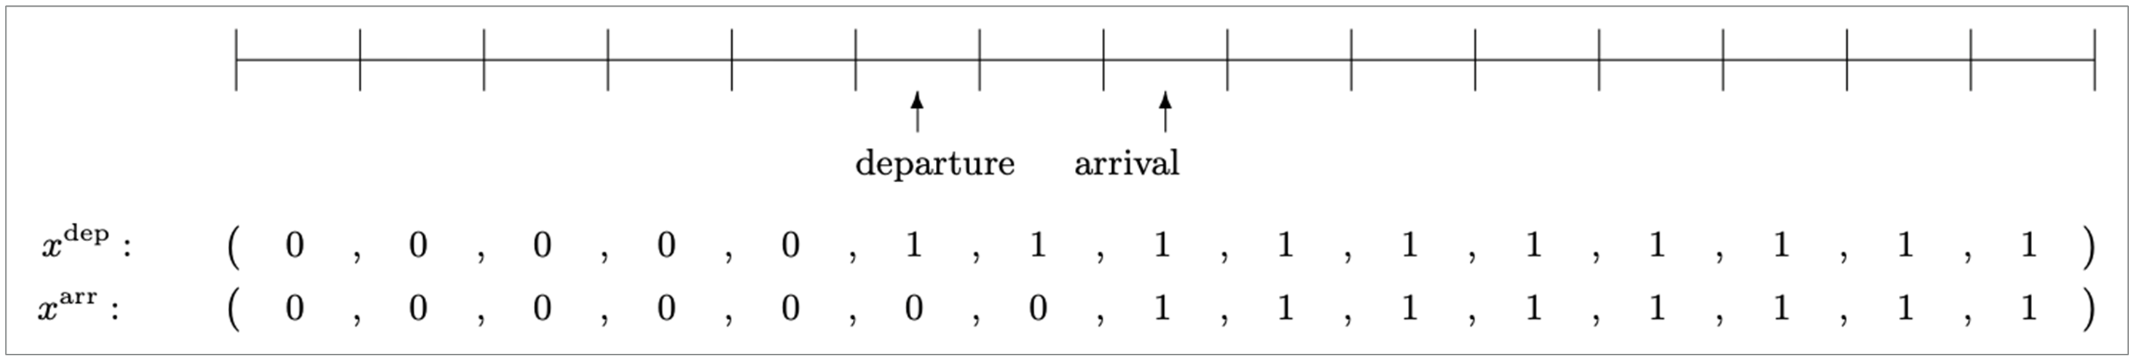
This makes writing many constraints much easier. For example, we can easily find the flight time for flight $i$ by subtracting the two decision variables: $\displaystyle \sum_{t\in\mathcal{T}} (x_{it}^{\text{dep}} - x_{it}^{\text{arr}})$.

### Optimization model

Recall the baseline model from recitation:

$$
\begin{align*}
\min		&	\quad	\sum_{i\in\mathcal{F}}\sum_{t\in\mathcal{T}}c_{it}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)-\sum_{t\in\mathcal{T}}h_{it}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right) \\
\text{s.t.}	&	\quad	x^\text{dep}_{it}\geq x^\text{dep}_{i,t-1} &	\forall i\in\mathcal{F},\forall t\in\mathcal{T}	 \\
		&	\quad	x^\text{arr}_{it}\geq x^\text{arr}_{i,t-1} &	\forall i\in\mathcal{F},\forall t\in\mathcal{T}	 \\
		&	\quad	x^\text{dep}_{i,\tau_i^\text{dep}-1}=0								&	\forall i\in\mathcal{F}							\\
		&	\quad	\sum_{t\in\mathcal{T}}x^\text{dep}_{it}-\sum_{t\in\mathcal{T}}x^\text{arr}_{it}\geq \Delta^{\text{min}}_i																				&	\forall i\in\mathcal{F}						\\
		&	\quad	\sum_{t\in\mathcal{T}}x^\text{arr}_{it}-\sum_{t\in\mathcal{T}}x^\text{dep}_{jt}\geq t^\text{min}_{ij}																						&	\forall (i,j)\in\mathcal{P}				\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{dep}}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right)\leq C_{kt}^\text{dep}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{arr}}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)\leq C_{kt}^\text{arr}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{dep}}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right)+\sum_{i\in\mathcal{F}_k^\text{arr}}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)\leq C_{kt}^\text{tot}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
		&	\quad	x^\text{arr}_{it},x^\text{dep}_{it}\in\{0,1\}&	\forall i\in\mathcal{F},\forall t\in\mathcal{T}
\end{align*}
$$

### Model inputs

We'll be experimenting with different model parameters, so let's define a function that generates all the model inputs given two parameters:
- `scenario` - airport capacity scenario (1 = high capacity / good weather conditions, 0 = low capacity / poor weather conditions)
- `timehorizon` - the length of the time horizon, in hours. This in turn defines which flights we are considering in the model.

Note that we set `scenario` for the entire country, meaning all airports have the same weather conditions. We will revisit this assumption in one of our later extensions.

In [5]:
def generateInputs(scenario, timehorizon):

    #Find the first and last period indices
    period_first = 1 + next(i for i, row in periods_full.iterrows()
                        if row["d"] == 18 and row["h"] == 6 and row["q"] == 0)  # 6:00am on Sept. 18th

    period_last = 1 + next(i for i, row in periods_full.iterrows()
                       if row["d"] == 18 and row["h"] == 6 + timehorizon - 1 and row["q"] == 45) # timehorizon hours later

    #Filter the flights down to those with a departure or arrival during our selected time period
    dep_flights = (schedule_full["dep"] >= period_first) & (schedule_full["dep"] <= period_last)
    arr_flights = (schedule_full["arr"] >= period_first) & (schedule_full["arr"] <= period_last)
    all_flights = dep_flights | arr_flights

    # Total number of selected flights
    n = all_flights.sum()

    # Total number of periods in the selected window + 1 (sink period)
    T = sum((np.arange(1, T_full + 1) >= period_first) & (np.arange(1, T_full + 1) <= period_last)) + 1

    # Filter schedules to those in the time window
    schedule_fullperiods = schedule_full[all_flights].copy()

    # Adjust period indices or set to -1 if outside window
    schedule = schedule_fullperiods.map(
        lambda x: x - period_first + 1 if period_first <= x <= period_last else -1
    )

    # Determine which flights are arrivals, departures
    Farr = arr_flights[all_flights].reset_index(drop=True)
    Fdep = dep_flights[all_flights].reset_index(drop=True)

    # Filter airport mappings
    FkDep = []
    FkArr = []
    for k in range(len(airports)):
        col = FkDep_full[all_flights][airports[k]]
        indices = np.flatnonzero(col)
        FkDep.append(indices.tolist())
        col = FkArr_full[all_flights][airports[k]]
        indices = np.flatnonzero(col)
        FkArr.append(indices.tolist())
    blocktimes_full = schedule_full.arr - schedule_full.dep

    # Filter block times
    Delta = blocktimes_full[all_flights].reset_index(drop=True)

    # Prepare connection filters
    dep_flights_next = np.append(dep_flights[1:].values, False)  # shift left with False padding
    connections_window_full = (tmin_full["tmin"] > 0) & arr_flights & dep_flights_next
    connections_window = connections_window_full[all_flights].reset_index(drop=True)

    # Get tmin values for filtered flights
    tmin_window = tmin_full[all_flights]["tmin"].reset_index(drop=True)

    # Indices where connections exist
    connections_indices = connections_window[connections_window].index

    # Build connection DataFrame
    connections = pd.DataFrame({
        "arr": connections_indices,       #Arriving flight
        "dep": connections_indices + 1,   #Departing flight (connecting flight)
        "tmintau": tmin_window.loc[connections_indices].values   #Min turn time between arrival and departure
    })

    # Initialize cost matrices
    c = np.zeros((n, T))
    h = np.zeros((n, T))
    c_departingflights = np.zeros((n, T))

    for i in range(n):
        dep_time = schedule.iloc[i, 0]
        arr_time = schedule.iloc[i, 1]

        if Farr[i] == 1 and Fdep[i] == 1:
            for t in range(T):
                if t + 1 > arr_time:
                    c[i, t] = (t + 1 - arr_time) ** 1.1
                if t + 1 > dep_time:
                    h[i, t] = (t + 1 - dep_time) ** 1.1 - (t + 1 - dep_time) ** 1.05

        elif Farr[i] == 1 and Fdep[i] == 0:
            for t in range(T):
                if t + 1 > arr_time:
                    c[i, t] = (t + 1 - arr_time) ** 1.1

        elif Farr[i] == 0 and Fdep[i] == 1:
            for t in range(T):
                if t + 1 > dep_time:
                    c_departingflights[i, t] = (t + 1 - dep_time) ** 1.1


    #Generate airport capacities based on scenario parameter (1 = high, 0 = low)
    capacity = np.zeros((K, 3))
    for k in range(K):
        airport_index = capacity_full[capacity_full["Airport"] == airports[k]].index[0]
        if scenario == 1:
            capacity[k] = capacity_full.loc[airport_index, ["arr-high", "dep-high", "tot-high"]]
        else:
            capacity[k] = capacity_full.loc[airport_index, ["arr-low", "dep-low", "tot-low"]]

    return T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity


### Code the model

We will define a model with different parameters for our different extensions so we can use a single function for all of them. Don't worry about the details of the extensions now, but the parameters are as follows:
- `Deltamin`, `blocktime_upperbound_flag`, `Deltamax` - Parameters for the added vehicle speeds. Set `blocktime_upperbound_flag = False` for now.
- `equity_flag`, `equity_weight` - Parameters for the the equity objectives. Set `equity_flag = False` for now.

In [6]:
def ATFM(capacity, Deltamin, blocktime_upperbound_flag, Deltamax, equity_flag, equity_weight):

    start_time = time.time()

    model = pulp.LpProblem("ATFM", pulp.LpMinimize)

    #Decision variables
    xArr = [[pulp.LpVariable(f"xArr_{i}_{t}", cat=pulp.LpBinary) for t in range(T)] for i in range(n)]
    xDep = [[pulp.LpVariable(f"xDep_{i}_{t}", cat=pulp.LpBinary) for t in range(T)] for i in range(n)]

    for i in range(n):
        if Fdep[i]:
            if schedule.iloc[i, 0] > 1:
                model += xDep[i][schedule.iloc[i, 0] - 2] == 0
            model += xDep[i][T - 1] == 1
        if Farr[i]:
            model += xArr[i][T - 1] == 1

    for i in range(n):
        if Farr[i] == 1 and Fdep[i] == 0:
            min_arrival_time = schedule_fullperiods.iloc[i, 0] + Deltamin[i] - period_first + 1
            if min_arrival_time > 1:
                model += xArr[i][int(min_arrival_time) - 2] == 0

    # Objective
    obj = []
    for i in range(n):
        for t in range(1, T):
            if Farr[i] == 1 and Fdep[i] == 1:
                obj.append(c[i][t] * (xArr[i][t] - xArr[i][t-1]))
                obj.append(-h[i][t] * (xDep[i][t] - xDep[i][t-1]))
            elif Farr[i] == 1 and Fdep[i] == 0:
                obj.append(c[i][t] * (xArr[i][t] - xArr[i][t-1]))
            elif Farr[i] == 0 and Fdep[i] == 1:
                obj.append(c_departingflights[i][t] * (xDep[i][t] - xDep[i][t-1]))

    #---------------- IGNORE UNTIL EQUITY EXTENSION ----------------#
    # Add the equity objective
    if equity_flag:
        # New decision variable
        max_cost_airline = pulp.LpVariable("max_cost_airline", lowBound=0)

        # Add constraints to define max_cost_airline
        for j in range(Nairlines):
            airline_cost = []

            for i in flights_on_airline[j]:
                for t in range(1, T):
                    if Farr[i] == 1 and Fdep[i] == 1:
                        airline_cost.append(c[i][t] * (xArr[i][t] - xArr[i][t-1]))
                        airline_cost.append(-h[i][t] * (xDep[i][t] - xDep[i][t-1]))
                    elif Farr[i] == 1 and Fdep[i] == 0:
                        airline_cost.append(c[i][t] * (xArr[i][t] - xArr[i][t-1]))
                    elif Farr[i] == 0 and Fdep[i] == 1:
                        airline_cost.append(c_departingflights[i][t] * (xDep[i][t] - xDep[i][t-1]))

            #Add constraint
            model += (max_cost_airline >= (1 / total_flights_airline.iloc[j]) * sum(airline_cost))

        #Add objective term for equity
        obj.append(equity_weight * max_cost_airline)
    #---------------------------------------------------------------#

    #Add objective to the model
    model += pulp.lpSum(obj)

    #Constraints

    for i in range(n):
        for t in range(1, T):
            model += xArr[i][t-1] <= xArr[i][t]
            model += xDep[i][t-1] <= xDep[i][t]

    #Block times
    for i in range(n):
        if Fdep[i] == 1 and Farr[i] == 1:
            model += pulp.lpSum(xDep[i]) - pulp.lpSum(xArr[i]) >= Deltamin[i]
    #---------------- IGNORE UNTIL SPEED EXTENSION -----------------#
    if blocktime_upperbound_flag:
        for i in range(n):
            if Fdep[i] == 1 and Farr[i] == 1:
                model += pulp.lpSum(xDep[i]) - pulp.lpSum(xArr[i]) <= Deltamax[i]
    #---------------------------------------------------------------#

    for idx, row in connections.iterrows():
        i = int(row['arr'])
        j = int(row['dep'])
        tmin_ij = row['tmintau']
        model += pulp.lpSum([xArr[i][t] - xDep[j][t] for t in range(T)]) >= tmin_ij

    for k in range(K):
        model += pulp.lpSum([xArr[i][0] for i in FkArr[k]]) <= capacity[k, 0]
        model += pulp.lpSum([xDep[i][0] for i in FkDep[k]]) <= capacity[k, 1]
        model += pulp.lpSum([xArr[i][0] for i in FkArr[k]]) + \
                 pulp.lpSum([xDep[i][0] for i in FkDep[k]]) <= capacity[k, 2]

    for t in range(1, T - 1):
        for k in range(K):
            model += pulp.lpSum([xArr[i][t] - xArr[i][t-1] for i in FkArr[k]]) <= capacity[k, 0]
            model += pulp.lpSum([xDep[i][t] - xDep[i][t-1] for i in FkDep[k]]) <= capacity[k, 1]
            model += pulp.lpSum([xArr[i][t] - xArr[i][t-1] for i in FkArr[k]]) + \
                     pulp.lpSum([xDep[i][t] - xDep[i][t-1] for i in FkDep[k]]) <= capacity[k, 2]

    build_duration = time.time() - start_time
    print("Model with horizon", timehorizon, "built in", build_duration, "seconds")

    start_time2 = time.time()
    model.solve(pulp.HiGHS(msg=False, timeLimit=60))
    solve_duration = time.time() - start_time2
    print("Model with horizon", timehorizon, "solved in", solve_duration, "seconds")

    sol = pulp.value(model.objective)
    xArrOPT = np.array([[pulp.value(xArr[i][t]) for t in range(T)] for i in range(n)])
    xDepOPT = np.array([[pulp.value(xDep[i][t]) for t in range(T)] for i in range(n)])

    if equity_flag:
        return sol, xArrOPT, xDepOPT
    else:
        return sol, xArrOPT, xDepOPT


### Initial model

Below is the process we will use to generate an instance and solve it throughout the homework.

In [ ]:
#Set parameters
timehorizon = 6

#Generate inputs with scenario = 1
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)

#Solve model
starttime = time.time()
sol_high, xArrOPT_high, xDepOPT_high = ATFM(capacity, Delta, False, Delta, False, 0)
cpu_high = timesince(starttime)

#Generate inputs with scenario = 0
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(0, timehorizon)

#Solve model
starttime = time.time()
sol_low, xArrOPT_low, xDepOPT_low = ATFM(capacity, Delta, False, Delta, False, 0)
cpu_low = timesince(starttime)

Model with horizon 6 built in 13.124240159988403 seconds
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 508869 rows; 491200 cols; 2580805 nonzeros; 491200 integer variables (491200 binary)
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [7e-02, 3e+01]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 6e+01]
Presolving model
301461 rows, 300308 cols, 1724787 nonzeros  1s
228729 rows, 232165 cols, 1361277 nonzeros  6s
204591 rows, 207971 cols, 1205955 nonzeros  21s
Presolve reductions: rows 204591(-304278); columns 207971(-283229); nonzeros 1205955(-1374850) 


In [ ]:
print("Objective with high capacities = ", sol_high)
print("Objective with low capacities = ", sol_low)

## Different time horizons

In or initial model, we planned all arrivals and departures over a 6 hour time horizon. Now, we experiment with slightly shorter and slightly longer time horizons (4, 5, and 7 hours) to see the impact on the solution quality and computational time.

In [ ]:
#Four hours
timehorizon = 4
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)
starttime = time.time()
sol_4hours, xArrOPT_4hours, xDepOPT_4hours = ATFM(capacity, Delta, False, Delta, False, 0)
CPU_4hours = timesince(starttime)

#Five hours
timehorizon = 5
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)
starttime = time.time()
sol_5hours, xArrOPT_5hours, xDepOPT_5hours = ATFM(capacity, Delta, False, Delta, False, 0)
CPU_5hours = timesince(starttime)

#Six hours
#This is our initial model, no need to re-do

#Seven hours
timehorizon = 7
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)
starttime = time.time()
sol_7hours, xArrOPT_7hours, xDepOPT_7hours = ATFM(capacity, Delta, False, Delta, False, 0)
CPU_7hours = timesince(starttime)

In [ ]:
df = pd.DataFrame({
    "Horizon": [4, 5, 6, 7],
    "Solution": [sol_4hours, sol_5hours, sol_high, sol_7hours],
    "CPU": [CPU_4hours, CPU_5hours, cpu_high, CPU_7hours]
})
df

### Question 1

**What is the impact of the time horizon on the optimization model?**

A) As the time horizon becomes longer, the computational times because longer because the model is larger.

B) As the time horizon becomes longer, the computational times because shorter because the model has more flexibility to find good solutions.

C) As the time horizon becomes longer, the cost increases because more flights need to be rescheduled.

D) As the time horizon becomes longer, the cost decreases because the model has more flexibility to find good solutions.

## Regional weather scenarios

As mentioned above, setting the weather scenario for the entire country is not realistic, as weather varies across regions. In this extension, we set the weather conditions by region of the couuntry and compare results across 8 different scenarios.

In [ ]:
#Read in airport location data
airports_lat_long = pd.read_csv("data_atfm/airports_lat_long.csv")
Nscenarios = 8

#Scenario descriptions
#scenario 0: good weather all around
#scenario 1: good weather in the East, broadly defined (top 20 in terms of longitude)
#scenario 2: good weather in the West, broadly defined (top 20 in terms of longitude)
#scenario 3: good weather in the East, moderately defined (top 15 in terms of longitude)
#scenario 4: good weather in the West, moderately defined (top 15 in terms of longitude)
#scenario 5: good weather in the East, narrowly defined (top 10 in terms of longitude)
#scenario 6: good weather in the West, narrowly defined (top 10 in terms of longitude)
#scenario 7: poor weather all around

#Create airport groups
top10_east = airports_lat_long.sort_values("longitude", ascending=False).head(10)
top10_west = airports_lat_long.sort_values("longitude", ascending=True).head(10)
top15_east = airports_lat_long.sort_values("longitude", ascending=False).head(15)
top15_west = airports_lat_long.sort_values("longitude", ascending=True).head(15)
top20_east = airports_lat_long.sort_values("longitude", ascending=False).head(20)
top20_west = airports_lat_long.sort_values("longitude", ascending=True).head(20)

#Scenario descriptions
print("In scenario 0, all airports operate under good-weather conditions")
print("In scenario 1, the following airports operate under good-weather conditions: " + ", ".join(top20_east["code"]))
print("In scenario 2, the following airports operate under good-weather conditions: " + ", ".join(top20_west["code"]))
print("In scenario 3, the following airports operate under good-weather conditions: " + ", ".join(top15_east["code"]))
print("In scenario 4, the following airports operate under good-weather conditions: " + ", ".join(top15_west["code"]))
print("In scenario 5, the following airports operate under good-weather conditions: " + ", ".join(top10_east["code"]))
print("In scenario 6, the following airports operate under good-weather conditions: " + ", ".join(top10_west["code"]))
print("In scenario 7, all airports operate under poor-weather conditions")

#Define high capacity airport set for each scenario
high_airport_sets = [set(airports_lat_long["code"]), set(top20_east["code"]), set(top20_west["code"]), set(top15_east["code"]),
                         set(top15_west["code"]), set(top10_east["code"]), set(top10_west["code"]), set([])]

### Create the capacity scenarios

In [ ]:
#Fill in the capacity for airport k in scenario s
def fill_in_capacity(k, s, high_airport_set):
    airport = airports[k]
    airport_index = capacity_full.index[capacity_full["Airport"] == airport][0]

    if airport in high_airport_set:
        #High capacity
        capacity_scenarios[k, 0, s] = capacity_full.loc[airport_index, "arr-high"]
        capacity_scenarios[k, 1, s] = capacity_full.loc[airport_index, "dep-high"]
        capacity_scenarios[k, 2, s] = capacity_full.loc[airport_index, "tot-high"]
    else:
        #Low capacity
        capacity_scenarios[k, 0, s] = capacity_full.loc[airport_index, "arr-low"]
        capacity_scenarios[k, 1, s] = capacity_full.loc[airport_index, "dep-low"]
        capacity_scenarios[k, 2, s] = capacity_full.loc[airport_index, "tot-low"]

In [ ]:
capacity_scenarios = np.zeros((K, 3, Nscenarios))

for s in range(Nscenarios):
    for k in range(K):
        fill_in_capacity(k, s, high_airport_sets[s])

In [ ]:
#Reset inputs
timehorizon = 6
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, _ = generateInputs(1, timehorizon)

#initialize arrays
xArrOPT_all = np.zeros((n, T, Nscenarios))
xDepOPT_all = np.zeros((n, T, Nscenarios))

#initialize DataFrame
df = pd.DataFrame(columns=["Scenario", "Solution"])

#Solve model for each scenario
for scenario in range(Nscenarios):
    sol, xArrOPT, xDepOPT = ATFM(capacity_scenarios[:, :, scenario], Delta, False, Delta, False, 0)

    #append row
    df = pd.concat([df, pd.DataFrame([{"Scenario": scenario, "Solution": sol}])], ignore_index=True)

    #assign slices
    xArrOPT_all[:, :, scenario-1] = xArrOPT
    xDepOPT_all[:, :, scenario-1] = xDepOPT

In [ ]:
df

### Question 2

**What is the impact of capacity on the optimization solution?**

(a) In Scenario 3, weather is worse than in Scenario 1 so airport capacities are lower, the model gets more constrained, and the cost increases.

(b) Scenarios 1 and 2 have the same number of airports with good and poor weather conditions, so the total cost is identical in both solutions.

(c) Poor weather in the West tends to be more costly for air traffic flow management systems than poor weather in the East, generally speaking.

(d) Scenario 3 has more airports with poor weather than Scenario 2, so airport capacities are lower under Scenario 3 and the total cost is therefore larger under Scenario 3.

### Look at the solution for one specific scenario

In [ ]:
scenario = 1

#Create a dataframe describing the optimal schedule in the scenario
opt_schedule = pd.DataFrame(columns=["dep", "arr"])
for i in range(n):
    if Fdep[i] == 1:
        idx = np.where(xDepOPT_all[i, :, scenario] == 1)[0]
        dep_time = (idx[0] + 1) if idx.size > 0 else (T + 1)
    else:
        dep_time = -1

    if Farr[i] == 1:
        idx = np.where(xArrOPT_all[i, :, scenario] == 1)[0]
        arr_time = (idx[0] + 1) if idx.size > 0 else (T + 1)
    else:
        arr_time = -1

    opt_schedule.loc[len(opt_schedule)] = {"dep": dep_time, "arr": arr_time}

#Calculate delays for the solution
dep_delay = opt_schedule["dep"].to_numpy() - schedule["dep"].to_numpy()
arr_delay = np.maximum(opt_schedule["arr"].to_numpy() - schedule["arr"].to_numpy(), 0)

#Find airborne holds
airborne_hold = np.zeros(n)
for i in range(n):
    if Fdep[i] == 1 and Farr[i] == 1:
        airborne_hold[i] = arr_delay[i] - dep_delay[i]
    elif Fdep[i] == 0 and Farr[i] == 1:
        airborne_hold[i] = arr_delay[i]

#Airport-level DataFrame
delay_airport = pd.DataFrame(columns=["airport", "departure", "airborne", "arrival"])
for t in range(T-1):
    for k in range(K):
        delay_airport.loc[len(delay_airport)] = {
            "airport": airports[k],
            "departure": sum(dep_delay[i] for i in FkDep[k]),
            "airborne":  sum(airborne_hold[i] for i in FkArr[k]),
            "arrival":   sum(arr_delay[i] for i in FkArr[k])
        }

delay_long = delay_airport.melt(id_vars=["airport"],
                                var_name="type",
                                value_name="count")

delay_long["count"] = delay_long["count"] * 15     # each period is 15 minutes

### Visualize the delays

In [ ]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

# Create grouped bar chart
fig = px.bar(
    delay_long,
    x="airport",
    y="count",
    color="type",
    barmode="group",
    title=f"Delays by airport in Scenario {scenario}",
    labels={"count": "Total delays (minutes)", "airport": "Airport"},
    width=1000,
    height=400
)

# Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=45,
    legend=dict(title="Type", orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

### Question 3

**Recall that Scenario 1 has good weather in the East, but poor weather in the West. Select all statements that are correct.**

A) JFK (New York) faces higher delays than SFO (San Francisco) under Scenario 1, consistent with the weather pattern.

B) SFO (San Francisco) faces higher delays than JFK (New York) under Scenario 1, consistent with the weather pattern.

C) JFK (New York) faces higher delays than SFO (San Francisco) under Scenario 1. This can be explained by the comparatively higher demand at JFK, relative to capacity.

D) JFK (New York) faces higher delays than SFO (San Francisco) under Scenario 1. This can be explained by network interdependencies, which impact operations at JFK and SFO.

### Question 4

**In Scenario 1, DEN faces poor weather conditions and BOS faces good weather conditions. DEN (Denver) has higher airborne delays and lower departure delays than BOS (Boston). Which of the following assertions can explain this observation?**

A) DEN has higher arrival demand comparatively to its poor-weather capacity than BOS comparitively to its good-weather capacity.

B) Airborne delays are penalized more in the objective function at BOS than at DEN.

C) Network interdependencies under Scenario 1 lead to higher imbalances between arrivals and capacity at DEN than at BOS.

D) The air traffic managers do a better job at absorbing delays on the ground (the main goal of ground delay programs) at BOS than at DEN.

## Modeling Extension: Added flexibility in block times

### Question 5

In the baseline model, we assume that each flight had a minimum flying time equal to its scheduled block time, and that there was no maximum flying time. In practice, however, flights can speed up en route and face an upper limit on their en-route times (for instance, due to fuel considerations). Let $\Delta^{min}_i$ and $\Delta^{max}_i$ denote the minimum and maximum flying times of flight $i$, respectively.

**Which of the following constraints capture these requirements?**

A) $$\Delta^{\text{min}}_i \leq \sum_{t\in\mathcal{T}}t \: \cdot \: x^\text{arr}_{it}-\sum_{t\in\mathcal{T}} t \: \cdot \:  x^\text{dep}_{it} \leq \Delta^{\text{max}}_i \quad\forall i\in\mathcal{F}$$
B) $$\Delta^{\text{min}}_i \leq \sum_{t\in\mathcal{T}}t \: \cdot \: x^\text{dep}_{it}-\sum_{t\in\mathcal{T}} t \: \cdot \:  x^\text{arr}_{it} \leq \Delta^{\text{max}}_i \quad\forall i\in\mathcal{F}$$

C) $$\Delta^{\text{min}}_i \leq \sum_{t\in\mathcal{T}}x^\text{arr}_{it}-\sum_{t\in\mathcal{T}}x^\text{dep}_{it} \leq \Delta^{\text{max}}_i	\quad\forall i\in\mathcal{F}$$

D) $$\Delta^{\text{min}}_i \leq \sum_{t\in\mathcal{T}}x^\text{dep}_{it}-\sum_{t\in\mathcal{T}}x^\text{arr}_{it} \leq \Delta^{\text{max}}_i	\quad\forall i\in\mathcal{F}$$


### Reset inputs

In [ ]:
timehorizon = 6
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)

### Read in block time data, and solve the model

We read in the minimum and maximum block times from a CSV. Note that originally, the block times (stored in `Delta[i]` for flight `i`) are the *scheduled* block times for each flight. The new data contains the minimum and maximum block time, which satisfies `Deltamin[i] <= Delta[i] <= Deltamax[i]` for flight `i`.

In [ ]:
blocktimes_flex_full = pd.read_csv("data_atfm/block_times.csv")
Deltamin = blocktimes_flex_full.loc[all_flights, :]["min"].reset_index(drop=True)
Deltamax = blocktimes_flex_full.loc[all_flights, :]["max"].reset_index(drop=True)

### Solve the new model

We solve the model for four different sets of parameters.
- Min block time of `Delta`, no max block time
- Min block time of `Deltamin`, no max block time
- Min block time of `Delta`, max block time of `Deltamax`
- Min block time of `Deltamin`, max block time of `Deltamax`

In [ ]:
sol1, xArrOPT1, xDepOPT1 = ATFM(capacity, Delta, False, Delta, False, 0);
sol2, xArrOPT2, xDepOPT2 = ATFM(capacity, Deltamin, False, Deltamax, False, 0);
sol3, xArrOPT3, xDepOPT3 = ATFM(capacity, Delta, True, Deltamax, False, 0);
sol4, xArrOPT4, xDepOPT4 = ATFM(capacity, Deltamin, True, Deltamax, False, 0);

In [ ]:
df = pd.DataFrame({
    "Scenario": [1, 2, 3, 4],
    "lower_limit": ["scheduled", "faster", "scheduled", "faster"],
    "upper_limit": ["unrestricted", "unrestricted", "restricted", "restricted"],
    "Solution": [sol1, sol2, sol3, sol3]
})
df

### Question 6

**What is the impact of speed flexibility on the optimization model?**

A) The maximum block time constraint does not have impact on the solution because regardless the model has incentives to keep flight durations and flight delays as low as possible.

B) Speed flexibility ("faster" lower limit on flying times) has a significant impact on the optimal solution because faster speeds enable lower delays.

C) If the maximum block time constraint was having an impact, then we would expect the total cost to go down when moving from the "unrestristed" solution to the "restricted" solution.

D) Without investigating the solutions, we know that speed flexibility ("faster" lower limit on flying times) leads to lower departure delays and lower airborne delays.

## Modeling Extension: Interairline equity

The original model considers all flights together, without consideration of the airline each flight. The final delay assignments can thus become inequitable, with a majority of delayed flights being on one or two airlines. We can remedy this by adjusting our optimization model to consider "airline equity". We introduce a new decision variable $E$ to capture this equity and add it to the objective weighted by a penalty term $\lambda$.
$$E = \text{the maximum "cost" borne by any single airline}$$

We also introduce one new set:
$$\mathcal{F}_j = \text{the set of flights that belong to ariline $j$}$$

## Optimization model

The new optimization model is presented below, with changes from the original model highlighted in red.

$$
\begin{align*}
\min		&	\quad	\sum_{i\in\mathcal{F}} \left( \sum_{t\in\mathcal{T}}c_{it}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)-\sum_{t\in\mathcal{T}}h_{it}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right) \right) \color{red}{+ \lambda \cdot E} \\
\text{s.t.}	&	\quad	x^\text{dep}_{it}\geq x^\text{dep}_{i,t-1} &	\forall i\in\mathcal{F},\forall t\in\mathcal{T}	 \\
		&	\quad	x^\text{arr}_{it}\geq x^\text{arr}_{i,t-1} &	\forall i\in\mathcal{F},\forall t\in\mathcal{T}	 \\
		&	\quad	x^\text{dep}_{i,\tau_i^\text{dep}-1}=0								&	\forall i\in\mathcal{F}							\\
		&	\quad	\sum_{t\in\mathcal{T}}x^\text{dep}_{it}-\sum_{t\in\mathcal{T}}x^\text{arr}_{it}\geq \Delta^{\text{min}}_i																				&	\forall i\in\mathcal{F}						\\
		&	\quad	\sum_{t\in\mathcal{T}}x^\text{arr}_{it}-\sum_{t\in\mathcal{T}}x^\text{dep}_{jt}\geq t^\text{min}_{ij}																						&	\forall (i,j)\in\mathcal{P}				\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{dep}}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right)\leq C_{kt}^\text{dep}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{arr}}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)\leq C_{kt}^\text{arr}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
		&	\quad	\sum_{i\in\mathcal{F}_k^\text{dep}}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right)+\sum_{i\in\mathcal{F}_k^\text{arr}}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)\leq C_{kt}^\text{tot}						&	\forall k\in\mathcal{K},\forall t\in\mathcal{T}	\\
        &   \quad   \color{red}{ E \geq \frac{1}{|\mathcal{F}_i|} \sum_{i\in\mathcal{F}_j} \left( \sum_{t\in\mathcal{T}}c_{it}\left(x^\text{arr}_{it}-x^\text{arr}_{i,t-1}\right)-\sum_{t\in\mathcal{T}}h_{it}\left(x^\text{dep}_{it}-x^\text{dep}_{i,t-1}\right)\right)}  &\quad \forall j\in\mathcal{J}\\
		&	\quad	x^\text{arr}_{it},x^\text{dep}_{it}\in\{0,1\}&	\forall i\in\mathcal{F},\forall t\in\mathcal{T}
\end{align*}
$$

### Question 7

**How is the formulation encoding the "cost" borne by each airline?**

A) total cost across all of the flights from the airline

B) total delay across all of the flights from the airline

C) average per-flight cost for the airline

D) average per-flight delay for the airline

### Question 8

**What is the objective of the model, in words?**

A) minimizing total delay cost

B) maximizing inter-airline equity, where inter-airline equity is encoded as the difference between the per-flight delay costs borne by different airlines

C) maximizing inter-airline equity, where inter-airline equity is encoded as the largest per-flight delay cost across all airlines

D) a multi-objective formulation that balances minimizing total delay cost and maximizing inter-airline equity, where inter-airline equity is encoded as the difference between the costs borne by different airlines

E) a multi-objective formulation that balances minimizing total delay cost and maximizing inter-airline equity, where inter-airline equity is encoded as the largest per-flight delay cost across all airlines

### Running the new model with equity

Import the data that shows which flights belong to which airline. Note that there are 7 airlines listed, but these represent 6 major airlines and 1 "Other" category that is an aggregation of flights from all other airlines.

In [ ]:
timehorizon = 4
T, n, all_flights, FkDep, FkArr, Fdep, Farr, period_first, period_last, schedule, schedule_fullperiods, Delta, connections, c, h, c_departingflights, capacity = generateInputs(1, timehorizon)

flights_airline_full = pd.read_csv("data_atfm/flights_airline.csv")
flights_airline = flights_airline_full.loc[all_flights, :]
total_flights_airline = flights_airline.sum(axis=0)

Nairlines = len(total_flights_airline)
print("Total airlines =", Nairlines)

flights_on_airline = [[] for _ in range(n)]
for i in range(n):
    j = np.where(flights_airline.iloc[i,:] == 1)[0][0]     #Find the index that = 1 (i.e. the airline j that flight i is assigned to
    flights_on_airline[j].append(i)

### Run the optimization model for three different values of $\lambda$

In [ ]:
equity_weight_all = np.array([1, 10, 100])
Nlambda = len(equity_weight_all)

solutions_all = np.zeros(Nlambda)
cost_airline_all = np.zeros((Nlambda, Nairlines))
max_cost_airline_all = np.zeros(Nlambda)
total_cost_all = np.zeros(Nlambda)

for equity_weight_index, equity_weight_val in enumerate(equity_weight_all):

    print(f"----- LAMBDA = {equity_weight_val} -----")
    sol, xArrOPT, xDepOPT = ATFM(capacity, Delta, False, Delta, True, equity_weight_val);
    solutions_all[equity_weight_index] = sol

    # Compute per-airline costs
    for j in range(Nairlines):
        airline_cost = 0

        #Add terms
        for i in flights_on_airline[j]:
            for t in range(1, T):
                if Farr[i] == 1 and Fdep[i] == 1:
                    airline_cost += c[i][t] * (xArrOPT[i][t] - xArrOPT[i][t-1])
                    airline_cost += -h[i][t] * (xDepOPT[i][t] - xDepOPT[i][t-1])
                elif Farr[i] == 1 and Fdep[i] == 0:
                    airline_cost += c[i][t] * (xArrOPT[i][t] - xArrOPT[i][t-1])
                elif Farr[i] == 0 and Fdep[i] == 1:
                    airline_cost += c_departingflights[i][t] * (xDepOPT[i][t] - xDepOPT[i][t-1])

        cost_airline_all[equity_weight_index, j] = airline_cost / total_flights_airline.iloc[j]

    # Max airline cost for this lambda
    max_cost_airline_all[equity_weight_index] = np.max(cost_airline_all[equity_weight_index, :])

    # Total system cost
    total_cost = 0
    for i in range(n):
        for t in range(1, T):
            if Farr[i] == 1 and Fdep[i] == 1:
                total_cost += (c[i][t] * (xArrOPT[i][t] - xArrOPT[i][t-1]))
                total_cost += (-h[i][t] * (xDepOPT[i][t] - xDepOPT[i][t-1]))
            elif Farr[i] == 1 and Fdep[i] == 0:
                total_cost += (c[i][t] * (xArrOPT[i][t] - xArrOPT[i][t-1]))
            elif Farr[i] == 0 and Fdep[i] == 1:
                total_cost += (c_departingflights[i][t] * (xDepOPT[i][t] - xDepOPT[i][t-1]))

    total_cost_all[equity_weight_index] = total_cost

In [ ]:
df = pd.DataFrame({
    "equity_weight": equity_weight_all,
    "total_delay_cost": total_cost_all,
    "max_airline_per_flight_cost": max_cost_airline_all
})
df

### Question 9

**Compare the solution with `equity_weight = 10` and the solution with `equity_weight = 100`. Which of the following assertions are true?**

A) The total delay cost is lower in the solution with `equity_weight = 100`.

B) The total delay cost is higher in the solution with `equity_weight = 100`.

C) Based on the table above, the solution with `equity_weight = 100` is better for every airline.

D) Based on the table above, the solution with `equity_weight = 100` is better for at least one airline.

# Part 2: Dock capacity planning for Citi Bike

New York City's bike-share program, Citi Bike, operates over 30 million rides each year in the city, making it the largest such program in the United States. Classic bikes and e-bikes are stored at stations around the city, each bike parked in a dock that holds the bike until the next rider comes along. During peak times, docks near busy destinations are completely full, while docks near popular origin points are empty. Citi Bike responds in real time to via manual bike re-balancing (sending employees to move bikes from full stations to empty stations) and incentivized re-balancing through their Bike Angel program (paying users to ride bikes from full stations to empty ones). They can also optimize the dock capacity of the stations, often adding more capacity at popular origins and destinations to accommodate increased flow of bikes. In this case study, we will do just that.

First, we will import the data.

## Import bike station data for Manhattan

In [ ]:
#Read in station information
stations = pd.read_csv("data_citi/station_info.csv")
n = stations.shape[0]
print("Number of stations = ", n)

#Add a station index column
stations['station_index'] = [i for i in range(n)]

#Add a lookup row for any locations not located in Manhattan (marked -1 in the data)
stations.loc[len(stations)] = {"station_id": -1, "lat": 0, "lon": 0, "capacity": 1e10, "station_index": -1}

### Distance between all station pairs (in kilometers)

In [ ]:
#Read in distances between stations (in kilometers)
walking_distance = pd.read_csv("data_citi/distances.csv", header=None)

### Historical inventory data

In [ ]:
#Read inventory
inventory = pd.read_csv("data_citi/bike_availability.csv")

#Add total slots for each time period (functioning bikes + functioning docks)
inventory["total_slots"] = inventory.avg_num_cbikes + inventory.avg_num_ebikes  + inventory.avg_num_dock

### Create visualizations of the station network

In [ ]:
# Load NYC borough boundaries
from geodatasets import get_path
from shapely.geometry import Point
path_to_file = get_path('nybb')
boroughs = gpd.read_file(path_to_file)

# Filter for Manhattan (borough name = 'Manhattan')
manhattan = boroughs[boroughs['BoroName'] == 'Manhattan']

# Make sure boroughs are also in EPSG:4326
manhattan = manhattan.to_crs(epsg=4326)

Below is a function `visualizeStations` that takes in a list of latitude coordinates `lats` and longitude coordinates `lons` and plots them on a map of Manhattan. Additionally, each station is colored according to its value in list `station_color` according to a gradient scale (colors specified by parameter `colormap`). We also specify the labels of the visualization with parameters `colordescription` and `plottitle`.

For the purposes of the first question, we also set `circle_midtown_flag = True` to circle the region known as "Midtown".

We will use this to visualize historical input data, and later, our solutions to the optimization model.

In [ ]:
def visualizeStations(lats, lons, station_color, colormap, colordescription, plottitle, circle_midtown_flag, maxvalue=None):

    n_target = len(lats)

    if maxvalue == None:
        maxvalue = max(station_color)

    points = gpd.GeoDataFrame(
        {"value": station_color},
        geometry=[Point(lons[i], lats[i]) for i in range(n_target)],
        crs="EPSG:4326"  # WGS84
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 10))
    manhattan.boundary.plot(ax=ax, color="black", linewidth=1)
    points.plot(ax=ax,
                column="value",
                cmap=colormap, # try 'coolwarm', 'inferno', 'Greens', 'Blues', etc.
                legend=True,
                legend_kwds={
                    "label": colordescription,   # <-- legend title
                    "orientation": "vertical"     # or "horizontal"
                },
                vmin=0,
                vmax=maxvalue,
                markersize=30)

    if circle_midtown_flag:
        circle = Circle(
            (-73.978039, 40.757003),   # (x=lon, y=lat)
            radius=0.013,          # degrees (~1km) — adjust as needed
            fill=False,           # only outline
            color="black",
            linewidth=3
        )
        ax.add_patch(circle)

    plt.title(plottitle)
    plt.show()

In [ ]:
# Create visualization for a specific day
target_day = 6         # Tuesday August 6, 2024 (Our data goes from August 4 - August 10)
target_hour = 10       # 10:00 am
inventory_singletimeperiod = inventory[(inventory.day == target_day) & (inventory.hour == target_hour)].reset_index(drop=True)
n_target = len(inventory_singletimeperiod)
inventory_singletimeperiod["bike_pct"] = [100 * (inventory_singletimeperiod.avg_num_cbikes[i] + inventory_singletimeperiod.avg_num_ebikes[i]) / (max(1,inventory_singletimeperiod.total_slots[i])) for i in range(n_target)]
inventory_singletimeperiod = inventory_singletimeperiod.join(stations, lsuffix='', rsuffix='_other')
inventory_singletimeperiod

visualizeStations(list(inventory_singletimeperiod.lat), list(inventory_singletimeperiod.lon), list(inventory_singletimeperiod.bike_pct),
                  "RdBu", "Percentage of bikes available", f"Historical Manhattan bike and dock availability at {target_hour}:00", True)

In [ ]:
# Create visualization for a specific day
target_day = 6         # Tuesday August 6, 2024 (Our data goes from August 4 - August 10)
target_hour = 12       # 12:00 pm
inventory_singletimeperiod = inventory[(inventory.day == target_day) & (inventory.hour == target_hour)].reset_index(drop=True)
n_target = len(inventory_singletimeperiod)
inventory_singletimeperiod["bike_pct"] = [100 * (inventory_singletimeperiod.avg_num_cbikes[i] + inventory_singletimeperiod.avg_num_ebikes[i]) / (max(1,inventory_singletimeperiod.total_slots[i])) for i in range(n_target)]
inventory_singletimeperiod = inventory_singletimeperiod.join(stations, lsuffix='', rsuffix='_other')
inventory_singletimeperiod

visualizeStations(list(inventory_singletimeperiod.lat), list(inventory_singletimeperiod.lon), list(inventory_singletimeperiod.bike_pct),
                  "RdBu", "Percentage of bikes available", f"Historical Manhattan bike and dock availability at {target_hour}:00", True)

In [ ]:
# Create visualization for a specific day
target_day = 6         # Tuesday August 6, 2024 (Our data goes from August 4 - August 10)
target_hour = 14       # 2:00 pm
inventory_singletimeperiod = inventory[(inventory.day == target_day) & (inventory.hour == target_hour)].reset_index(drop=True)
n_target = len(inventory_singletimeperiod)
inventory_singletimeperiod["bike_pct"] = [100 * (inventory_singletimeperiod.avg_num_cbikes[i] + inventory_singletimeperiod.avg_num_ebikes[i]) / (max(1,inventory_singletimeperiod.total_slots[i])) for i in range(n_target)]
inventory_singletimeperiod = inventory_singletimeperiod.join(stations, lsuffix='', rsuffix='_other')
inventory_singletimeperiod
print(target_hour)

visualizeStations(list(inventory_singletimeperiod.lat), list(inventory_singletimeperiod.lon), list(inventory_singletimeperiod.bike_pct),
                  "RdBu", "Percentage of bikes available", f"Historical Manhattan bike and dock availability at {target_hour}:00", True)

### Question 1

**What is a potential explanation for the difference in bike availability in Midtown Manhattan (the circled region) at 10am versus 12pm versus 2pm?** Recall this data is from a Tuesday.

A) The area is full of bikes at 10am, meaning many people commute to work there sometime before 10am

B) Bikes begin to arrive to the area after 10am, meaning it could be a popular tourist destination

C) Many bikes arrive to the area around 12pm and leave shortly after, meaning it is likely a popular lunch destination

D) All of the bikes are gone from the area by 10am, meaning it is likely a residential area, and the docks fill up as people return home

### Let's look at one particular station in Midtown (station 6740.01)

The code below looks at the bike and dock inventory over the course of a week, starting on Sunday August 4th and stretching to Saturday August 10th.

In [ ]:
#Visualize bikes and docks over time for particular station
target_station = 6740.01
target_station_inventory = inventory[(inventory.station_id == target_station)]
y1 = list(target_station_inventory.avg_num_cbikes + target_station_inventory.avg_num_ebikes) #Sum the classic bikes and e-bikes, as they use the same docks
y2 = list(target_station_inventory.avg_num_dock)

#Create plot with matplotlib
for k in range(0,169,24):
    plt.axvline(x=k, color='gray', linewidth=0.5, linestyle='dashed')
plt.plot(y1, label ='Bikes', color='dodgerblue')
plt.plot(y2, label ='Docks', color='firebrick', linestyle='dashed')
plt.xlabel("Time period (hour)")
plt.ylabel("Quantity")
plt.legend()
plt.xticks(range(0,169,24))
plt.title(f'Bikes and Docks per Hour for station {target_station}')

### Question 2

**Assuming demand does not change, how do you expect the inventory levels of station 6740.01 and its neighboring stations might change if 50 docks were added to 6740.01?**

A) Station 6740.01 would run out of bikes less frequently (blue line hits zero less frequently)

B) Station 6740.01 would run out of docks less frequently (red dashed line hits zero less frequently)

C) Neighboring stations would run out of bikes less frequently

D) Neighboring stations would run out of docks less frequently

## Dock capacity optimization

Now we'll see if we can improve the bike-share system by adding dock capacity to a few stations. The existing dock capacities are visualized below.

In [ ]:
dockcapacities = [stations.capacity.iloc[i] for i in range(n)]
visualizeStations(list(inventory_singletimeperiod.lat), list(inventory_singletimeperiod.lon),
                  dockcapacities, "Reds", "Number of existing docks", "Existing dock capacity per station", False)

### Import the demand data

In [ ]:
#Read demand
demand = pd.read_csv("data_citi/demand_by_time_period.csv")

#Select the time periods we're considering for the optimization model
#We restrict to a single day just to retain a scalable optimization model for the homework
start_time_period, end_time_period = 48 * (target_day - 4), 48 * (target_day - 3)    #Tuesday only
Trange = range(start_time_period, end_time_period)
demand = demand[(demand.time_period_weekly >= start_time_period) & (demand.time_period_weekly < end_time_period)].reset_index(drop=True)

#Add station_index for start_station_id and end_station_id to the demand dataframe
demand = pd.merge(left=demand, right=stations, how='left', left_on=['start_station_id'], right_on=['station_id'])
demand = demand.drop(columns=['station_id', 'lat', 'lon', 'capacity'])
demand = demand.rename(columns={'station_index': 'start_station_index'})
demand = pd.merge(left=demand, right=stations, how='left', left_on=['end_station_id'], right_on=['station_id'])
demand = demand.drop(columns=['station_id', 'lat', 'lon', 'capacity'])
demand = demand.rename(columns={'station_index': 'end_station_index'})
print("Total demand =", sum(demand.demand), "trips")

#Get all triplets of (origin station, destination station, time period) tbat have non-zero demand, i.e. the set D
demandtriplets = [(demand.start_station_index[i].astype(int), demand.end_station_index[i].astype(int), demand.time_period_weekly[i]) for i in range(len(demand))]

### Visualize the total demand (measured in bikes departing)

In [ ]:
bikesdeparting = [sum(demand[(demand.start_station_index == i)].demand) for i in range(n)]
destinationtrips = [sum(demand[(demand.end_station_index == i)].demand) for i in range(n)]
visualizeStations(list(inventory_singletimeperiod.lat), list(inventory_singletimeperiod.lon),
                  bikesdeparting, "Blues", "Trip count", "Bike trips originating from each station (August 4-10)", False)

### Set the initial inventory using the historical inventory data

In [ ]:
#Set initial inventory
initial_inventory = inventory[(inventory.day == target_day) & (inventory.hour == 0)].reset_index(drop=True)
initial_inventory["initial_bikes"] = initial_inventory.avg_num_cbikes + initial_inventory.avg_num_ebikes
print("Average initial dock capacity = ", 100 * sum(initial_inventory.initial_bikes) / sum(initial_inventory.total_slots), "%")

#Add station index to the initial_inventory dataframe
initial_inventory = pd.merge(left=initial_inventory, right=stations, how='left', left_on=['station_id'], right_on=['station_id'])
initial_inventory["initial_bikes"] = [min(initial_inventory.initial_bikes[i], initial_inventory.capacity[i]) for i in range(len(initial_inventory))]
initial_inventory = initial_inventory.drop(columns=['lat', 'lon', 'capacity'])

### Optimization model

**Model inputs**
$$
\begin{align*}
n &= \text{number of stations} \\
d_{ij}^t &= \text{demand from station $i$ to station $j$ during time period $t$} \\
c_{ij} &= \text{walking distance from station $i$ to station $j$} \\
C_{i} &= \text{current dock capacity of station $i$} \\
v_{i} &= \text{initial inventory of bikes at station $i$} \\
B &= \text{budget of new docks to build} \\
\mu &= \text{penalty for not serving one unit of demand} \\
\end{align*}
$$

**Helpful sets**
$$
\begin{align*}
\mathcal{D} &= \text{all triplets of an origin station, destination station, and time period $(i,j,t)$ that have have non-zero demand, i.e. $d_{ij}^t >0$} \\
\mathcal{C}_{ij} &= \text{all pairs of stations $(k,\ell)$ such that $k$ is within walking distance of $i$ and $\ell$ is within walking distance of $j$} \\
\end{align*}
$$

**Decision variables**
$$
\begin{align*}
z_i &= \text{number of new docks built at station $i$} \\
x_{ij}^t &= \text{total number of bikes that ride from station $i$ to station $j$ in period $t$} \\
y^t_{(i,j),(k,\ell)} &= \text{the volume of demand with origin $i$ and destination $j$ that is assigned to ride from station $k$ to station $\ell$ in period $t$} \\
w_{ij}^t &= \text{the volume of demand with origin $i$ and destination $j$ that is not served in period $t$ (i.e. not assigned/could not find a bike and dock)} \\
u_i^t &= \text{the inventory of bikes at station $i$ at the start of period $t$} \\
\end{align*}
$$

The key dynamics of the flow variables $x$ and $y$ are described in the image below.

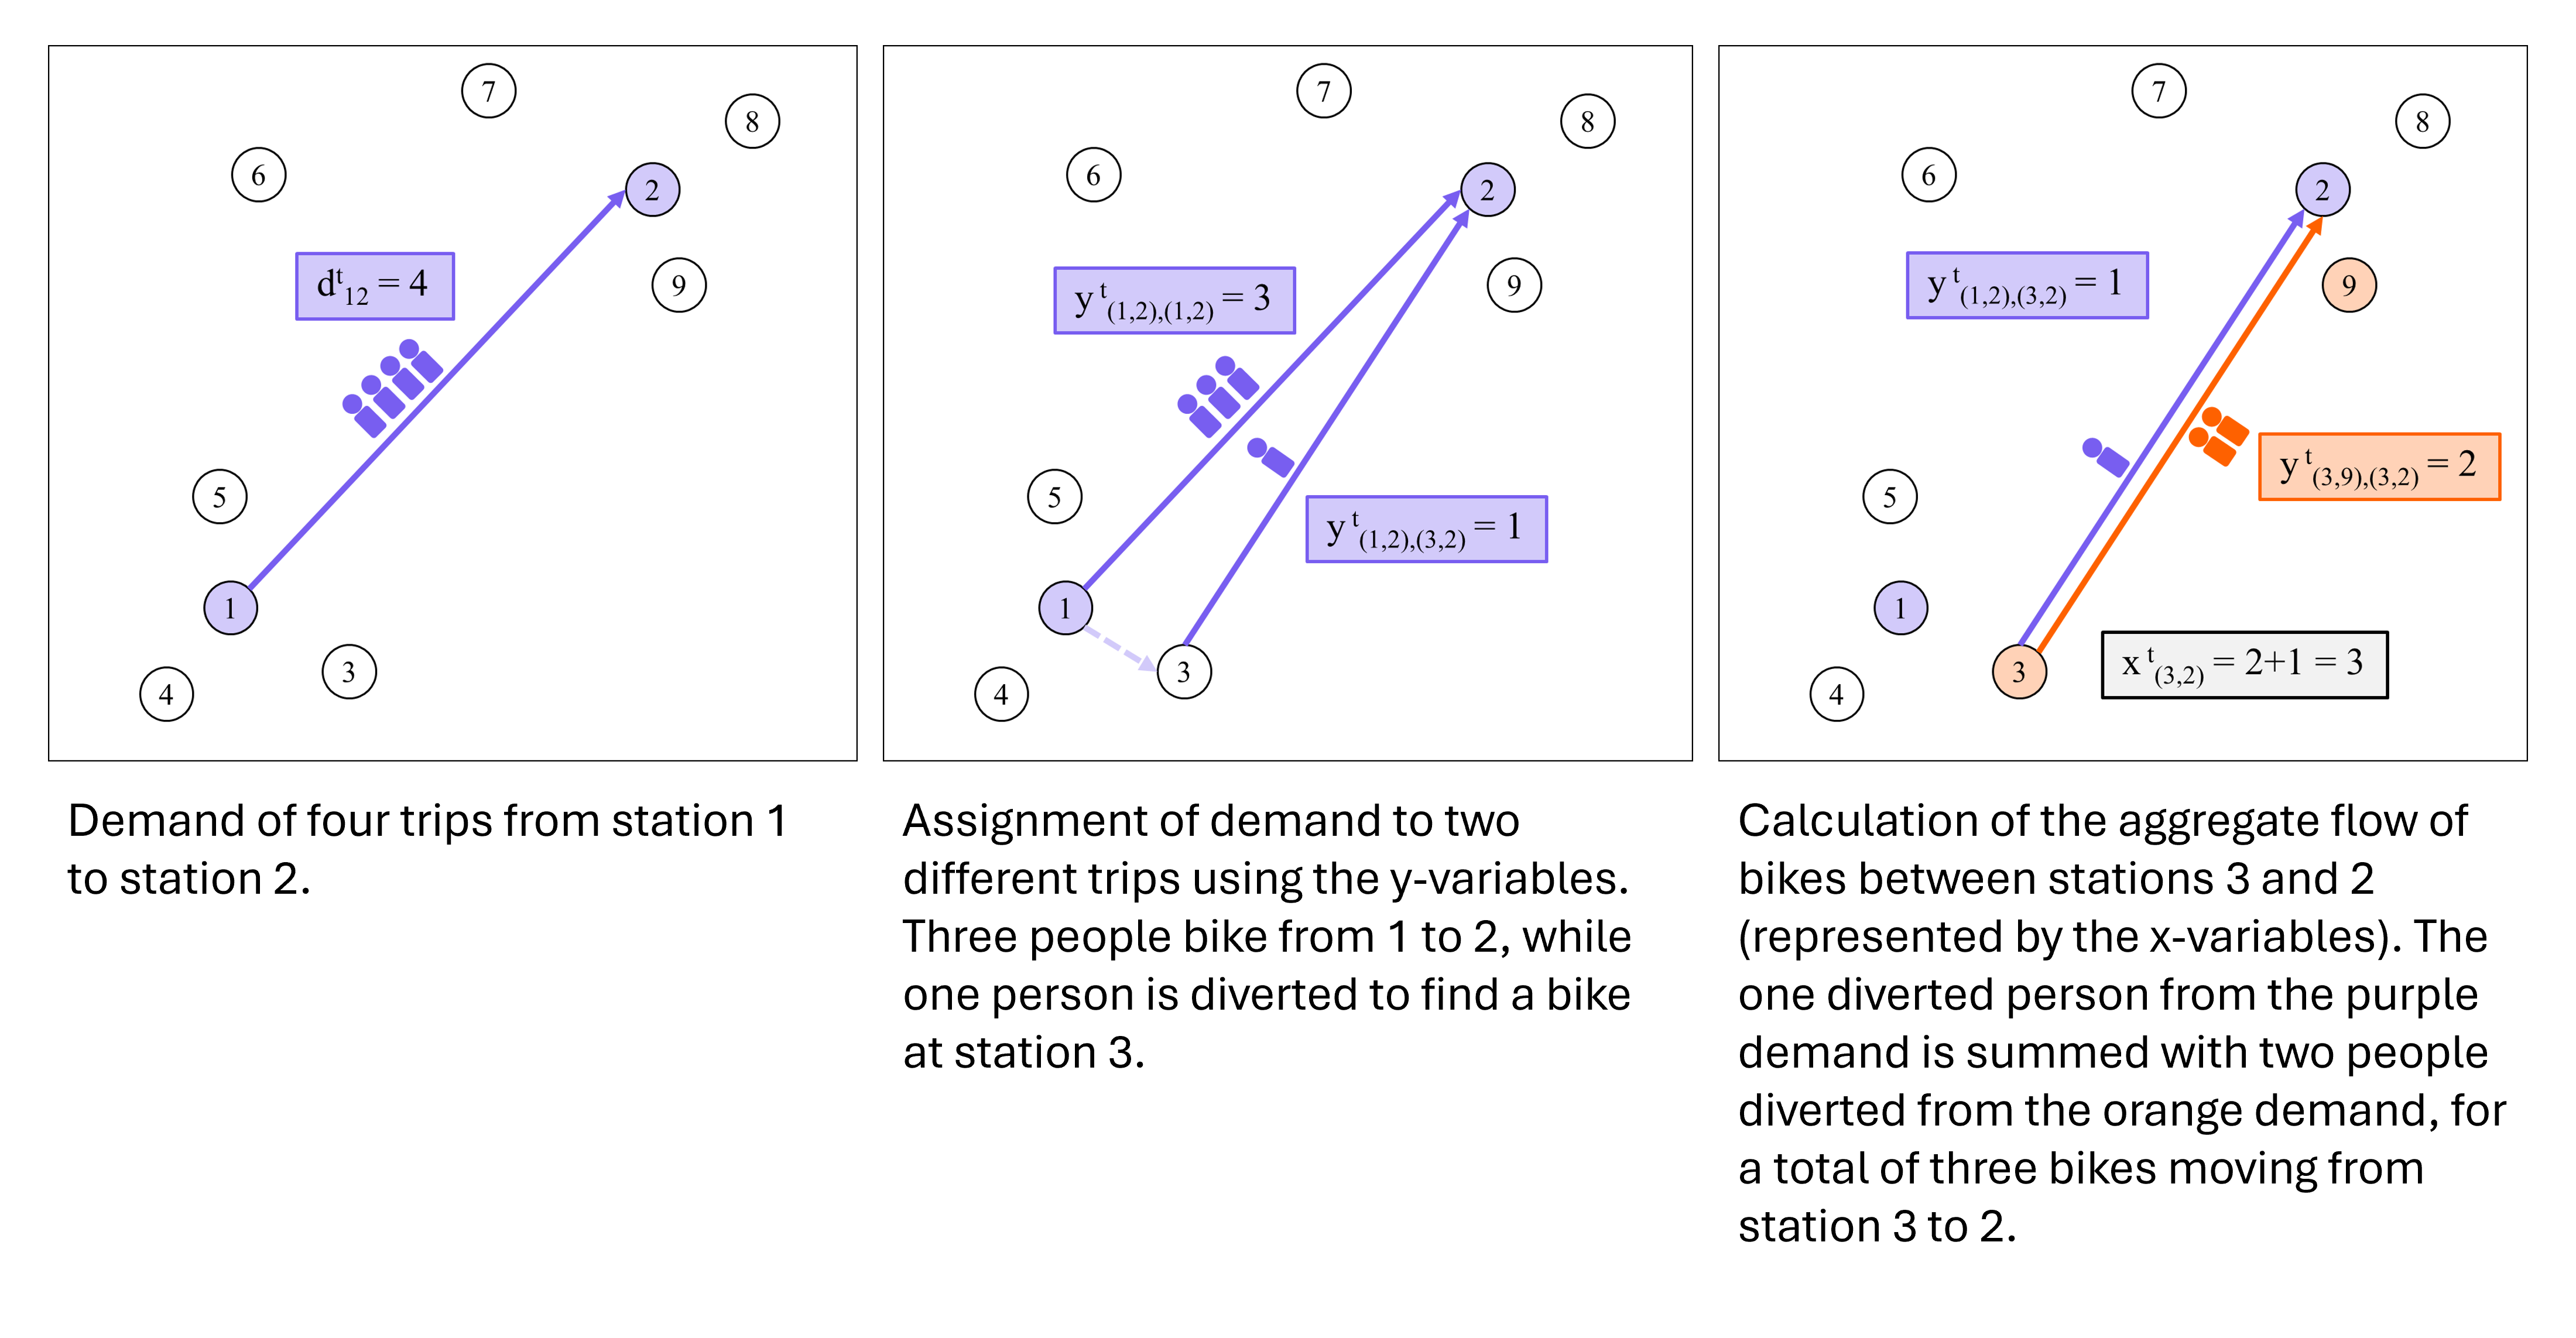
The optimization model is as follows:

$$
\begin{align}
\min \quad & \sum_{(i,j,t)\in \mathcal{D}} \sum_{(k,\ell) \in \mathcal{C}_{ij}} c_{ik} y^t_{(i,j),(k,\ell)} + \sum_{(i,j,t)\in \mathcal{D}} \sum_{(k,\ell) \in \mathcal{C}_{ij}} c_{\ell j}  y^t_{(i,j),(k,\ell)} + \mu \cdot \sum_{(i,j,t)\in \mathcal{D}} w_{ij}^t \\
\text{s.t.} \quad & \textbf{Budget of new docks} \\
& \sum_{i=1}^n z_i \leq B\\
& \textbf{Demand fulfillment and flow} \\
& \sum_{(k,\ell) \in \mathcal{C}_{ij}} y^t_{(i,j),(k,\ell)} = d_{ij}^t - w_{ij}^t \quad \forall (i,j,t)\in \mathcal{D}\\
& x^t_{ij} = \sum_{(k,\ell) \in \mathcal{C}_{ij}} y^t_{(k,\ell), (i,j)} \quad \forall (i,j,t) \in \mathcal{D}\\
& \textbf{Inventory dynamics} \\
& u^1_i = v_i  \quad \forall i \in \{1,\ldots,n\}\\
& u^t_i = u^{t-1}_i - \sum_{j} x_{ij}^{t-1} + \sum_{j} x_{ji}^{t-1} \quad \forall i \in \{1,\ldots,n\}, t \in \mathcal{T} \quad\quad\quad\quad\quad\quad\quad\quad (\star)\\
& u^t_i \leq C_i + z_i \quad \forall i \in \{1,\ldots,n\} \\
& \sum_{j} x_{ij}^t \leq u_i^t  \quad \forall i  \in \{1,\ldots,n\}, t \in \mathcal{T} \\
& \textbf{Variable bounds} \\
& y^t_{(i,j),(k,\ell)} \in \mathbb{Z}^+  \quad \forall (i,j,t)\in \mathcal{D}, (k,\ell) \in \mathcal{C}_{ij} \\
& z_i \in \mathbb{Z}^+ \quad \forall i \in \{1,\ldots,n\} \\
& u_i^t \geq 0 \quad \forall i \in \{1,\ldots,n\} , t \in \mathcal{T} \\
& w_{ij}^t \geq 0  \quad \quad \forall (i,j,t)\in \mathcal{D}
\end{align}
$$

### Question 3

What does constraint $(\star)$ enforce?

A) The total inventory at the start of time period $t$ is equal to the inventory from period $t-1$ minus the bikes departing from $i$ in period $t-1$ plus the bikes arriving to $i$ in period $t-1$.

B) The total inventory at the start of time period $t$ is equal to the inventory from period $t-1$ minus the bikes arriving to $i$ in period $t-1$ plus the bikes departing from  $i$ in period $t-1$.

C) The total number of bikes departing from station $i$ in period $t-1$ must be no more than the number of bikes in inventory at the start of period $t-1$.

D) The total number of bikes departing from station $i$ in period $t-1$ must be no fewer than the number of bikes in inventory at the start of period $t-1$.

### Question 4

The objective contains three terms for each user:
1. User walking distance $c_{ik}$ (in code, `walking_distance[i,k]`) to find an available bike near their origin
2. User walking distance $c_{\ell j}$ (in code, `walking_distance[l,j]`) to find an available dock near their destination
3. A penalty for missed demand, weighted by term $\mu$ (in code, `missed_trip_penalty`)

**We want to enforce that it is always preferable for a user to walk to a nearby station than it is to miss the demand and incur the penalty. To do so, what should $\mu = $ `missed_trip_penalty` be set to?**

A) It can be any positive number, depending on our goal

B) It should be less than `max_walk`

C) It should be equal to `max_walk`

D) It should be greater than `max_walk`

### Create the helpful sets for use in defining the optimization model

Note that we restrict the maximum walking distance of a user searcging for a bike or dock to `max_walk=0.13` kilometers. In reality, this quantity varies per user. We select this relatively small walking distance for to maintain tractability of the model by restricting the possible assignments.

In [ ]:
#Find stations within walking distance
max_walk = 0.13
stations_in_walking_distance = {i: [j for j in range(n) if walking_distance.iloc[i,j] <= max_walk] for i in range(n)}
stations_in_walking_distance[-1] = [-1]

#Find all feasible assignments for y-variables, i.e. a demand triplet (i,j,t) and a location k in walking distance of i and a location l in walking distance of j
feasibleassignments = []
for i,j,t in demandtriplets:
    for k in stations_in_walking_distance[i]:
        for l in stations_in_walking_distance[j]:
            feasibleassignments.append((i,j,t,k,l))

#Find all possible triplets for flows (x-variables)
alltriplets = list(set([(k,l,t) for i,j,t,k,l in feasibleassignments]))
corresponding_demands = {x: [] for x in alltriplets}
for i,j,t,k,l in feasibleassignments:
    corresponding_demands[k,l,t].append((i,j))

In [ ]:
#For writing the inventory dynamics constraint, find the triplets that enter and leave each station
flows_in = {(i,t): [] for i in range(n) for t in Trange}
flows_out = {(i,t): [] for i in range(n) for t in Trange}
for i,j,t in alltriplets:
    if i >= 0:
        flows_out[i,t].append(j)
    if j >= 0:
        flows_in[j,t].append(i)

### Code the model

In [ ]:
def dockCapacityModel(max_new_docks, station_capacity, max_new_docks_perstation, verbose):

    # Create model
    model = pulp.LpProblem("dockCapacity", pulp.LpMinimize)

    # Variables
    inv = pulp.LpVariable.dicts("inv", ([(i,t) for i in range(n) for t in Trange]), lowBound=0, cat='Integer')
    x = pulp.LpVariable.dicts("x", (alltriplets), cat='Integer')
    y = pulp.LpVariable.dicts("y", (feasibleassignments), lowBound=0, cat='Integer')
    z = pulp.LpVariable.dicts("z", (i for i in range(n)), lowBound=0, upBound=max_new_docks_perstation, cat='Integer')
    w = pulp.LpVariable.dicts("w", (demandtriplets), lowBound=0)

    # Objective
    missed_trip_penalty = 10*max_walk
    model += (pulp.lpSum(walking_distance.iloc[i,k] * y[i,j,t,k,l] for i,j,t,k,l in feasibleassignments if i >= 0)
              + pulp.lpSum(walking_distance.iloc[j,l] * y[i,j,t,k,l] for i,j,t,k,l in feasibleassignments if j >= 0)
              + pulp.lpSum(missed_trip_penalty * w[i,j,t] for i,j,t in demandtriplets))

    # Constraints

    # Total docks added
    model += (pulp.lpSum(z[i] for i in range(n)) <= max_new_docks)

    # Fulfill demand
    for ind in range(len(demand)):
        i, j, t = demand.start_station_index[ind], demand.end_station_index[ind], demand.time_period_weekly[ind]
        model += (pulp.lpSum(y[i,j,t,k,l] for k,l in corresponding_demands[i,j,t]) == demand.demand[ind] - w[i,j,t])

    # Consistency between y and x (aggregate flow variable)
    for i, j, t in alltriplets:
        model += (x[i,j,t] == pulp.lpSum(y[k,l,t,i,j] for k,l in corresponding_demands[i,j,t]))

    # Max bike inventory
    for i in range(n):
        for t in Trange:
            model += (inv[i,t] <= station_capacity.iloc[i] + z[i])

    # Initial inventory
    for i in range(n):
        model += (inv[i,start_time_period] == round(initial_inventory.initial_bikes[i]) )

    # Inventory dynamics at each station
    for i in range(n):
        for t in range(start_time_period+1, end_time_period):
            model += (inv[i,t] == inv[i,t-1] - pulp.lpSum(x[i, j, t-1] for j in flows_out[i,t-1] if i != j) + pulp.lpSum(x[j, i, t-1] for j in flows_in[i,t-1] if i != j)  )

    #Constrain trips leaving station i in period t by the starting inventory
    for i in range(n):
        for t in Trange:
            model += (pulp.lpSum(x[i, j, t] for j in flows_out[i,t]) <= inv[i,t])

    #Optimize
    model.solve(pulp.GUROBI(msg=verbose, timeLimit=60*5))  #CHANGE THE SOLVER NAME HERE IF DESIRED

    # Extract values after solving
    obj = pulp.value(model.objective)
    #invOPT = [pulp.value(inv[(i, start_time_period + 12*2)]) for i in range(n)]
    zOPT = {i: pulp.value(z[i]) for i in range(n)}

    print("------------------------------------------------------------")
    print("Objective = ", obj)
    pct_diverted = 100 * (pulp.lpSum(pulp.lpSum(pulp.value(y[i,j,t,k,l]) for k,l in corresponding_demands[i,j,t]) for i,j,t in demandtriplets) - pulp.lpSum(pulp.value(y[i,j,t,i,j]) for i,j,t in demandtriplets)) / pulp.lpSum(demand.demand[ind] for ind in range(len(demand)))
    pct_served = 100 * (1 - pulp.lpSum(pulp.value(w[i,j,t]) for i,j,t in demandtriplets) / pulp.lpSum(demand.demand[ind] for ind in range(len(demand))))
    print("------------------------------------------------------------")
    print(f"Percent of demand diverted = {pct_diverted}%")
    print(f"Percent of demand served = {pct_served}%")
    print("------------------------------------------------------------")

    return obj, zOPT

### Solve the model setting `new_docks = 0`

In [ ]:
new_docks = 0
objective_baseline, zOPT_baseline = dockCapacityModel(new_docks, stations.capacity, 0, False)

Overall, the Citi Bike dock capacities are already pretty good with our model! This is likely because the Citi Bike team carefully plans the capacities to best serve their demand already! Let's see if we can make it even better by further optimizing the capacities.

### Question 5

**Without evaluating the model, what can we say about how the objective value `objective_adddocks` of the model with `max_new_docks = 1000`, will compare to the objective of our baseline model, `objective_baseline`, with `max_new_docks = 0`?**

A) `objective_adddocks < objective_baseline`

B) `objective_adddocks <= objective_baseline`

C) `objective_adddocks > objective_baseline`

B) `objective_adddocks >= objective_baseline`

### Solve the model setting `new_docks = 1000`

In [ ]:
print("Existing docks =", sum(stations.capacity.iloc[i] for i in range(n)))
new_docks = 1000
docks_per_station_cap = 1000
objective_adddocks, zOPT_adddocks = dockCapacityModel(new_docks, stations.capacity, docks_per_station_cap, False)

In [ ]:
addedcapacitylocations = [i for i in zOPT_adddocks.keys() if zOPT_adddocks[i] > 0]
addedcapacityamounts = [zOPT_adddocks[i] for i in zOPT_adddocks.keys() if zOPT_adddocks[i] > 0]
max_docks_allocated = max(addedcapacityamounts)
print(f"Docks allocated to {len(addedcapacityamounts)} stations")
visualizeStations(list(inventory_singletimeperiod.lat[addedcapacitylocations]), list(inventory_singletimeperiod.lon[addedcapacitylocations]),
                  addedcapacityamounts, "Reds", "Docks added", f"Docks added in solution (new_docks = {new_docks})", True, max_docks_allocated)

### Question 6

**The solution puts a large portion of the additional capacity in just two stations, one in Lower Manhattan with 162 new docks and one near Midtown with 114 new docks. What are potential _disadvantages_ of such a solution?**

A) There may not be enough physical space to build all of the extra docks at those two stations.

B) Because all the docks are concentrated in a few stations instead of spread out, there are likely better solutions that serve more demand and have a lower total walking distance for the users.

C) This solution only helps bikers traveling to and from the stations allocated additional dock capacity. It would be better to allocate docks evenly across all stations.

D) During peak times, it will be less efficient for Citi Bike employees to manually re-balance many bikes when they are located at a small number of stations, versus if the bikes were spread across many stations.

### Solve the model setting `docks_per_station_cap = 30`

To see an alternate solution, we can set the `docks_per_station_cap` to ensure that no stations are allocated "too many" new docks.

In [ ]:
new_docks = 1000
docks_per_station_cap = 30
objective_adddocks_capped, zOPT_adddocks_capped = dockCapacityModel(new_docks, stations.capacity, docks_per_station_cap, False)

In [ ]:
addedcapacitylocations = [i for i in zOPT_adddocks_capped.keys() if zOPT_adddocks_capped[i] > 0]
addedcapacityamounts = [zOPT_adddocks_capped[i] for i in zOPT_adddocks.keys() if zOPT_adddocks_capped[i] > 0]
print(f"Docks allocated to {len(addedcapacityamounts)} stations")
visualizeStations(list(inventory_singletimeperiod.lat[addedcapacitylocations]), list(inventory_singletimeperiod.lon[addedcapacitylocations]),
                  addedcapacityamounts, "Reds", "Docks added", f"Docks added in solution (new_docks = {new_docks}, station cap = {docks_per_station_cap})", True, max_docks_allocated)

### Question 7

**Compared to the uncapped solution, what is the effect of capping the number of docks that can be opened at each station?**

A) More stations recieve additional dock capactity.

B) Fewer stations recieve additional dock capactity.

C) (Total walking distance + missed demand penalties) goes down, because we are spreading the new capacity across many stations.

D) (Total walking distance + missed demand penalties) goes up, because we are adding a new constraint to the model.

## Benchmark heuristic

### What if we had just added docks to the stations that are full most often in the historical data?

The simple heuristic executed below simply checks the historical inventory data, counts how many times each station was full (had no available docks), and allocates new docks proportionally.

In [ ]:
import math
from math import floor

#Find the count of time periods that each station is full
full_inventory = inventory[(inventory.avg_num_dock == 0) & (inventory.avg_num_cbikes + inventory.avg_num_ebikes > 0)]
full_count = full_inventory.groupby("station_id")["avg_num_dock"].count().reset_index()

#Distribute new_docks proportionally
full_count["fractional_allocation"] = new_docks * full_count.avg_num_dock / sum(full_count.avg_num_dock)
full_count["initial_allocation"] = [math.floor(x) for x in full_count.fractional_allocation]
full_count["fractional_remainder"] = full_count.fractional_allocation - full_count.initial_allocation
full_count = full_count.sort_values(by="fractional_remainder", ascending=False)
remaining_docks = new_docks - sum(full_count.initial_allocation)
full_count["remainder_allocation"] =  [1 if i < remaining_docks else 0 for i in range(len(full_count))]
full_count["final_allocation"] = full_count["initial_allocation"] + full_count["remainder_allocation"]

#Calculate the new capacities
newstations = stations.merge(full_count, how='left', left_on=['station_id'], right_on=['station_id'])
newstations["upgraded_capacity"] = newstations.capacity + newstations.final_allocation.fillna(0)

#Re-solve with the new capacities
objective_heuristic, zOPT_heuristic = dockCapacityModel(0, newstations.upgraded_capacity, 0, False)

In [ ]:
addedcapacitylocations = [i for i in range(n) if newstations.final_allocation.iloc[i] > 0]
addedcapacityamounts = [newstations.final_allocation.iloc[i] for i in range(n) if newstations.final_allocation.iloc[i] > 0]
visualizeStations(list(inventory_singletimeperiod.lat[addedcapacitylocations]), list(inventory_singletimeperiod.lon[addedcapacitylocations]),
                  addedcapacityamounts, "Reds", "Docks added", f"Docks added in solution (new_docks = {new_docks})", True, max_docks_allocated)

### Question 8

**The simple heuristic barely improves over the original solution with no new docks. Why might this be happening?**

A) The highest traffic stations are rarely *completely* full, because there is enough demand such that a few people are always nearby and taking bikes from them. Thus the heuristic gives too few bikes to these stations.

B)  The heuristic allocates new dock capacity to many stations that are frequently full, but have low traffic. Because the stations serve so little demand, adding docks improves our objective only marginally.

C) The heuristic uses historical inventory data, which may be skewed by manual re-balancing performed by Citi Bike.

D) The heuristic ignores spillover effects: some stations may have low demand, but could still benefit from more docks because nearby stations have high demand.